In [1]:
import os
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


In [2]:
import tensorflow as tf

In [3]:
tf.__version__

'1.14.0'

In [4]:
model = VGG16(weights='imagenet',include_top = True)

In [5]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def load_image(path):
    img = image.load_img(path, target_size = model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

#img, x = load_image("applianceImages/0/1944487656.jpg")
#print("shape of x: ", x.shape)
#print("data type: ", x.dtype)
#plt.imshow(img)

In [8]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [9]:
feat = feat_extractor.predict(x)
plt.figure(figsize=(16,4))
plt.plot(feat[0])

NameError: name 'x' is not defined

In [12]:
#NOTE: CHANGE THIS IF YOU WANT TO SWITCH DIR
images_path = 'train_1'
image_extensions = ['.jpg', '.png', '.jpeg']
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path)
         for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
print(len(images))
images = images[:1000]
print(len(images))

11025
1000


In [13]:
import time
tic = time.clock()

features = []
for i, image_path in enumerate(images):
    if i % 500 == 0:
        toc = time.clock()
        elap = toc-tic;
        print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(images), elap))
        tic = time.clock()
    img, x = load_image(image_path);
    feat = feat_extractor.predict(x)[0]
    features.append(feat)
    
print('finished extracting features for %d images' % len(images))

/Users/azg6els/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/Users/azg6els/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys
/Users/azg6els/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.


analyzing image 0 / 1000. Time: 0.0007 seconds.
analyzing image 500 / 1000. Time: 401.4357 seconds.
finished extracting features for 1000 images


In [37]:
features.length

AttributeError: 'list' object has no attribute 'length'

In [14]:
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)

PCA(copy=True, iterated_power='auto', n_components=300, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [18]:
pca_features = pca.transform(features)
pca_features.shape

(1000, 300)

In [11]:
import pickle

#with open('similarRoomFeatures.pkl', 'wb') as f:
    #pickle.dump(pca_features, f)

with open('similarFeatures.pkl', 'rb') as f:
    pca_features = pickle.load(f)

In [21]:
from scipy.spatial import distance

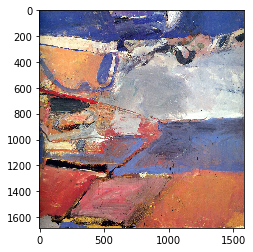

In [76]:
#DEMONSTRATION:
import random

# grab a random query image
query_image_idx = int(len(images) * random.random())

# let's display the image
anchorimg = image.load_img(images[query_image_idx])
plt.imshow(anchorimg)

In [77]:
similar_idx = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]

idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[1:6]


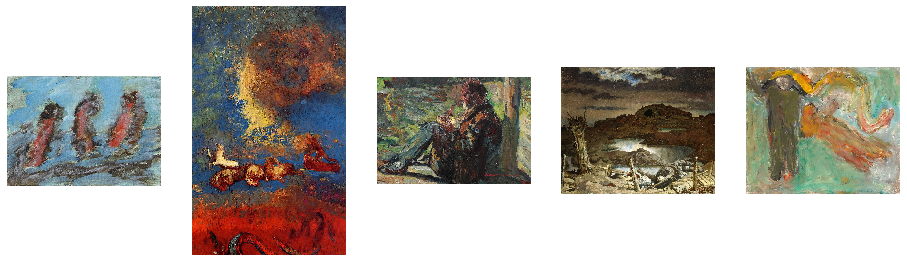

In [78]:
# load all the similarity results as thumbnails of height 100
thumbs = []
for idx in idx_closest:
    img = image.load_img(images[idx])
    thumbs.append(img)

# concatenate the images into a single image
#concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)

# show the image
#plt.figure(figsize = (16,12))
#plt.imshow(concat_image)
fig,axs = plt.subplots(1,5, figsize= (16,12))
for i in range(5):
    axs[i].imshow(thumbs[i])
    axs[i].axis('off')
    

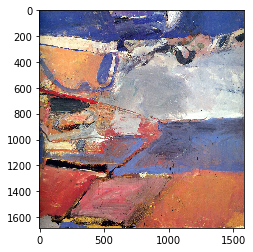

In [79]:
plt.imshow(anchorimg)